# Gradient descent solutions to most likely hidden state by MLE/MAP estimation

This notebook shows how one can use maximum likelihood estimation (MLE) or maximum a posteriori (MAP) estimation to find the most likely hidden state given some sensory observation via gradient descent instead of using the analytic solution.

==========================================================================

* **Notebook dependencies**:
    * ...

* **Content**: Jupyter notebook accompanying Chapter 2 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import sys
import torch

from torch.distributions import Normal
from typing import Union

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.utils import create_environment

mpl.style.use("seaborn-deep")

The last notebook examined how to find the most likely hidden state estimate after observing the sensory data based on just using the model likelihood (MLE) or the likelihood and the prior (MAP estimation). The result was an analytic update equation for the hidden state. 

We now turn our attention to the gradient descent solution to this problem which is an iterative optimization based approach. This demonstration also introduces the concept of gradient descent which will be important in the chapters that follow.

First we generate 500 data points under a linear generating function as we have done before.

**Note**: we will be using the `torch` package to perform gradient descent so we will need to be using Torch tensors instead of NumPy arrays.

In [2]:
# Environment parameters
env_params = {
    "beta_0_star" : 3,    # Linear parameter intercept
    "beta_1_star" : 2,    # Linear parameter slope
    "y_star_std"  : 0.5   # Standard deviation of sensory data
}

# Initialize environment and agent
env = create_environment(name="static_linear", params=env_params)

# Generate data for three different x_star values
x_star  = 2                                          # 3 different external states
N       = 500                                        # Number of samples
y       = np.zeros(N)                                # Empty array for i=20 samples

# Generate
for i in range(N):
    y[i] = env.generate(x_star)

# Convert numpy array for data into tensor
y = torch.tensor(y)

To perform gradient descent we need a loss function. We will use the loss function described in the previous chapter. These are different for MLE and MAP.
* MLE will use the negative log likelihood.
* MAP will use the negative log likelihood minus the log prior.

In [3]:
def generating_function(beta_0: float, beta_1: float, x: float) -> float:
    return beta_1 * x + beta_0

def mle_objective(x: float, y: Union[float, torch.tensor]) -> torch.tensor:
    
    # Parameters
    beta_0 = 3      # Linear generating function intercept
    beta_1 = 2      # Linear generating function slope
    var_y  = 0.5    # Likelihood variance
    
    # Linear genearting function
    mu_y   = generating_function(beta_0=beta_0, beta_1=beta_1, x=x)
    
    # Calculate log-likelihood over samples    
    log_likelihood = Normal(loc=mu_y, scale=np.sqrt(var_y)).log_prob(y).sum(axis=0)
    
    return -log_likelihood
    
def map_objective(x: float, y: Union[float, torch.tensor]) -> torch.tensor:
        
    # Parameters
    beta_0 = 3      # Linear generating function intercept
    beta_1 = 2      # Linear generating function slope
    var_y  = 0.5    # Likelihood variance
    m_x    = 2      # Prior mean
    s_x    = 0.25   # Prior variance
    
    # Linear generating function
    mu_y   = generating_function(beta_0=beta_0, beta_1=beta_1, x=x)
    
    # Calculate log-likelihood over samples    
    log_likelihood = Normal(loc=mu_y, scale=np.sqrt(var_y)).log_prob(y).sum(axis=0)
    
    # Calculate log-prior
    log_prior = Normal(loc=m_x, scale=s_x).log_prob(x)
    
    return -(log_likelihood + log_prior)

Next we need to perform **gradient descent** over our objective function. Let's refer to the objectives in question as $\mathcal{F}_{MLE}$ and $\mathcal{F}_{MAP}$ for MLE and MAP respectively. The aim is to find the minima of this objective function. This minima is the point where the negative log likelihood of the data is minimized (or the negative log likelihood of the data plus log prior assumptions for MAP). This represents the mode of the posterior. Since we are using Gaussian probability distributions, which are quadratic in construction, we will have a well-behaved objective function with a single minima. For each iteration $j \in \left \{0, \dots, J \right \}$ we perform the following update for MLE or MAP:

$$
    \begin{aligned}
        \textbf{MLE}: \hspace{5mm} x^{(j+1)} &\gets x^{(j)} - \kappa \frac{\partial \mathcal{F}_{MLE}}{\partial x^{(j)}} \\
        \textbf{MAP}: \hspace{5mm} x^{(j+1)} &\gets x^{(j)} - \kappa \frac{\partial \mathcal{F}_{MAP}}{\partial x^{(j)}}
    \end{aligned}
$$

where $\kappa$ (kappa) is a **learning rate**. This tells us that we make iterative updates to our running best guess about the value of $x$ by moving in the direction of steepest descent along our loss function, where steepest descent is calculated from the partial derivative of the loss function with respect to $x$. $\kappa$ tells us how big our step down the gradient will be and we are free to specify this hyperparameter ourselves.

This process has no clear termination so when do we stop? We could pick a hard stopping limit, say 100 iterations. Or, we could specify some tolerance. When the updates to the best guess of $x^{(j)}$ at the j-th iteration does not change within some tolerance we know that the process has essentially "flat-lined" or, more properly, **converged** at a local minima. In our case, since we are using a quadratic loss function, this local minima will be the global minima.

Note that we must also choose our initial value for $x$ before kicking off the process. We could choose this randomly or use some prior information about a best guess of where to start. Gradient descent is very sensitive to both the initialization and learning rate (kappa) and the performance of the algorithm depends highly on our choice. For our simple case these settings do not matter as much.

Below we define the gradient descent function. We will use the `torch` package for this purpose which contains functions for **auto-differentiation**. In other words, this package will allow us to easily calculate the partial derivative of the loss function so we do not have to do it by hand.

In [4]:
def gradient_descent(kappa: float, 
                     n_iterations: int, 
                     x: float, 
                     obj: callable):
    
    print(f"Initializing x at {x}.")
    
    # Initialize empty history arrays
    x_history    = torch.zeros(n_iterations)
    loss_history = torch.zeros(n_iterations)
    
    # Turn x into a Torch tensor which is differentiable
    x = torch.tensor(x, requires_grad=True)
    
    # Calculate loss at initialization
    loss = obj(x, y)
    
    # Add initialization values to history (j=0)
    x_history[0]    = x.item()
    loss_history[0] = loss
    
    # Gradient descent algorithm (for j+1...n_iterations)
    for j in range(n_iterations-1):
        obj_x = obj(x, y)  # Compute loss
        obj_x.backward()   # Compute gradient of tensor
        
        with torch.no_grad():
            x -= (kappa * x.grad)   # Step in direction of gradient
            x.grad.zero_()          # Zero out the gradients
        
        # Recalculate loss
        loss = obj(x, y)
        
        # Append to history
        x_history[j+1] = x.item()
        loss_history[j+1] = loss

    print(f"Final value of x: {np.round(x.item(), 3)}")
    history = {"x": x_history, "loss": loss_history}
    return history

In [5]:
mle_history = gradient_descent(
    kappa=0.00001, 
    n_iterations=100, 
    x=5., 
    obj=mle_objective)

Initializing x at 5.0.
Final value of x: 2.039


In [6]:
map_history = gradient_descent(
    kappa=0.00001, 
    n_iterations=100, 
    x=4., 
    obj=map_objective)

Initializing x at 4.0.
Final value of x: 2.021


In [7]:
# Assign history to variables for plotting purposes:
# Requires detaching gradients from tensor and converting to numpy array
mle_x    = mle_history["x"].detach().numpy()
mle_loss = mle_history["loss"].detach().numpy()
map_x    = map_history["x"].detach().numpy()
map_loss = map_history["loss"].detach().numpy()

<Figure size 640x480 with 0 Axes>

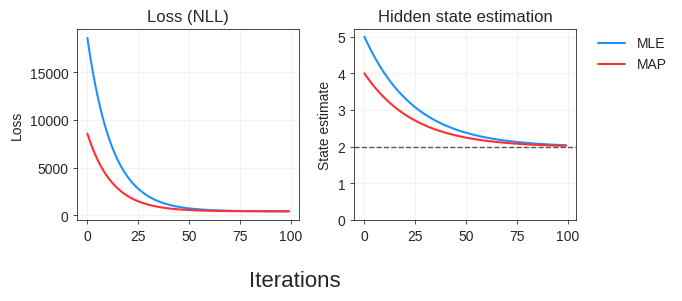

In [8]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1,2, facecolor=(1,1,1), figsize=(6, 3))

# Main plot
axes[0].plot(range(len(mle_loss)), mle_loss, c="#1e90ff")
axes[0].plot(range(len(map_loss)), map_loss, c="#ff3030")
axes[1].plot(range(len(mle_x)), mle_x, c="#1e90ff", label="MLE")
axes[1].plot(range(len(map_x)), map_x, c="#ff3030", label="MAP")

# Titles
axes[0].set_title("Loss (NLL)")
axes[1].set_title("Hidden state estimation")

# Axis labels
axes[0].set_ylabel("Loss")
axes[1].set_ylabel("State estimate")

# Hidden state estimate plot customization
axes[1].set_ylim([0, 5.2])
axes[1].axhline(y=2, linestyle="dashed", linewidth=1, c="#595959")

# Axis global labels
fig.supxlabel("Iterations", fontsize=16)

# Cosmetic changes 
for ax in axes:
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)

fig.legend(bbox_to_anchor=(1.14,0.9), loc='upper right', ncol=1)
fig.tight_layout()

Finally, we visualize the log-likelihood function (for MLE) and observe how gradient descent progressed down this function at each iteration. To obtain the NLL curve, we simply have to vary $x$ over the negative-log-likelihood as shown below. $x$ and the associated loss obtained above for each iteration of gradient descent can then be plotted onto the curve.

In [9]:
# Grid ranges (the range of values x can take)
x_min = 0.01
x_max = 5
x_points = 500

x_range = np.linspace(start=0.01, stop=5, num=500)
loss = [mle_objective(x, y) for x in x_range]

<Figure size 640x480 with 0 Axes>

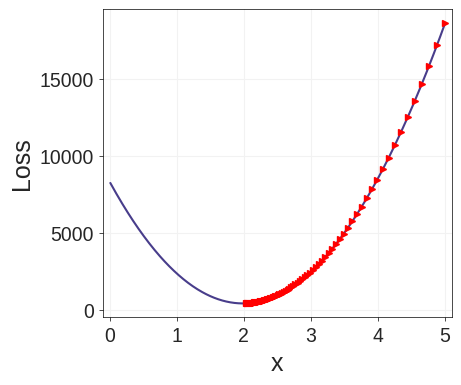

In [10]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, ax = plt.subplots(1, 1, facecolor=(1,1,1), figsize=(4.5,4))

# Plot NLL function
ax.plot(x_range, loss, c="#483D8B")
ax.plot(mle_x, mle_loss, "r>", ms=4.5)

# Set axes labels
ax.set_xlabel("x", fontsize=18)
ax.set_ylabel("Loss", fontsize=18)

ax.set_xlim([-0.1,5.1])
ax.set_xticks(range(0,6, 1))

# Axis labels and styling
ax.axes.grid(which="major", axis="both", c="#f2f2f2")
plt.setp(ax.spines.values(), color="black", linewidth=0.5)
ax.tick_params(
    labelsize=14,
    axis='both',          
    which='major',      
    bottom=True,
    left=True,
    color="black",
    width=0.5,
    length=3)